In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.linear_model import LinearRegression

import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService

In [2]:
# 所有filter函数
def factor_111(df, window=94):
    # 复制数据避免修改原始数据
    df = df.copy()
    
    # 1. 向量化计算基础指标
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std().replace(0, 1e-5)
    df['is_up'] = (df['close'] > df['open']).astype(int)
    df['is_down'] = (df['close'] < df['open']).astype(int)
    
    # 2. 向量化重心计算
    def vectorized_center(group, direction):
        dir_col = f'is_{direction}'
        # 获取分组索引和权重
        idx = group.index
        weights = group['fractal'] * group['volume']
        mask = (group[dir_col] == 1)
        
        # 向量化计算
        cum_weights = weights.where(mask, 0).cumsum()
        cum_weighted_idx = (pd.Series(range(len(group)), index=idx)
                          .where(mask, 0) * weights).cumsum()
        
        # 计算重心并处理边界条件
        center = cum_weighted_idx / cum_weights
        center.iloc[:4] = np.nan  # 前4个点不计算
        return center
    
    # 按日分组并行计算
    df['G_u'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'up'))
                 .reset_index(level=0, drop=True))
    
    df['G_d'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'down'))
                 .reset_index(level=0, drop=True))
    
    # 3. 滚动窗口向量化
    df['avg_fractal'] = df['fractal'].rolling(24, min_periods=12).mean()
    
    # 预计算有效索引
    valid_idx = df.dropna(subset=['G_u', 'G_d', 'avg_fractal']).index
    regression_data = np.full(len(df), np.nan)
    
    # 4. 滚动回归优化
    # 预计算累积矩阵 (X'X 和 X'y)
    X = df[['G_u', 'avg_fractal']].values
    y = df['G_d'].values
    
    # 初始化存储
    XTX = np.zeros((len(df), 2, 2))
    XTy = np.zeros((len(df), 2))
    valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    
    # 批量计算外积
    for i in range(len(df)):
        if valid_mask[i]:
            x_vec = X[i]
            XTX[i] = np.outer(x_vec, x_vec)
            XTy[i] = x_vec * y[i]
    
    # 计算累积和
    cum_XTX = np.nancumsum(XTX, axis=0)
    cum_XTy = np.nancumsum(XTy, axis=0)
    
    # 5. 向量化滚动回归
    for i in range(window, len(df)):
        start = i - window
        
        # 使用累积差计算窗口矩阵
        window_XTX = cum_XTX[i-1] - (cum_XTX[start-1] if start > 0 else 0)
        window_XTy = cum_XTy[i-1] - (cum_XTy[start-1] if start > 0 else 0)
        
        # 检查有效数据点数
        window_points = np.count_nonzero(valid_mask[start:i])
        if window_points < 10:
            continue
            
        try:
            # 求解线性方程组
            coeffs = np.linalg.solve(window_XTX, window_XTy)
            pred = X[i] @ coeffs
            residual = y[i] - pred
            regression_data[i] = residual * df['avg_fractal'].iloc[i]
        except np.linalg.LinAlgError:
            continue
    
    # 6. 后处理
    factor_series = pd.Series(-regression_data, index=df.index)
    return factor_series.fillna(0)

def high_freq_fractal_center_factor(df, window=96):
    """
    高频改进版：直接在15分钟线上计算分形重心
    核心创新：结合Hurst指数与波动聚集效应
    """
    # 基础计算
    df = df.copy()
    df['range'] = (df['high'] - df['low']) / df['open'].clip(lower=1e-5)
    df['body'] = (df['close'] - df['open']).abs() / df['open'].clip(lower=1e-5)
    
    # 改进的分形指标 ========================================
    # 1. 波动分形维度
    df['fractal_vol'] = df['range'].rolling(5).std() / df['range'].rolling(20).std()
    
    # 2. 价格Hurst指数 (简化计算)
    def hurst(series):
        lags = [2, 5, 10, 20]
        tau = []
        for lag in lags:
            rs = (series.diff(lag).abs().mean()) / (series.diff().abs().std() * np.sqrt(lag))
            tau.append(np.log(rs))
        return np.polyfit(np.log(lags), tau, 1)[0]
    
    df['hurst'] = df['close'].rolling(100).apply(hurst, raw=False)
    
    # 3. 量能分形维度
    df['volume_frac'] = (np.log1p(df['volume']).rolling(5).std() / (np.log1p(df['volume']).rolling(20).std()))
    
    # 综合分形指标
    df['fractal'] = (df['fractal_vol'] * 0.5 + 
                     (1 - df['hurst'].clip(-0.5, 1.5)) * 0.3 + 
                     df['volume_frac'] * 0.2)
    
    # 时间重心计算 (向量化) ================================
    # 时间索引归一化
    time_idx = np.arange(len(df)) / window
    
    # 上涨K线
    up_mask = df['close'] > df['open']
    up_weights = df['fractal'] * df['volume'] * up_mask
    G_u = (time_idx * up_weights).rolling(window).sum() / up_weights.rolling(window).sum()
    
    # 下跌K线
    down_mask = df['close'] < df['open']
    down_weights = df['fractal'] * df['volume'] * down_mask
    G_d = (time_idx * down_weights).rolling(window).sum() / down_weights.rolling(window).sum()
    
    # 重心偏离因子 ========================================
    # 标准化处理
    mean_G = (G_u + G_d) / 2
    factor_value = (G_d - G_u) * df['fractal']
    
    # 波动调整
    vol_level = df['range'].rolling(window).mean()
    factor_value = factor_value / (vol_level + 0.01)
    
    # 分形状态过滤
    high_fractal = df['fractal'] > df['fractal'].rolling(5*window).quantile(0.7)
    factor_value = factor_value * np.where(high_fractal, 1.5, 0.8)
    
    return -factor_value.fillna(0)

In [3]:
# 主程序
def calculate_filter_correlations():
    # 获取数据
    ds = DataService()
    df = ds['ETHUSDT_15m_2020_2025']['2021-10-01':]
    
    # 检查数据列是否完整
    required_columns = {'open', 'high', 'low', 'close', 'volume', 
                       'taker_buy_volume', 'trade_count'}
    missing_columns = required_columns - set(df.columns)
    
    if missing_columns:
        print(f"警告: 数据中缺少以下列: {missing_columns}")
        print("将跳过依赖这些列的filter计算")
    
    # 准备所有filter函数
    filters = {
        '111': factor_111,
        '222': high_freq_fractal_center_factor
    }
    
    # 创建结果DataFrame
    results = pd.DataFrame(index=df.index)
    
    # 计算所有filter值
    for name, func in filters.items():
        if func is None:
            continue  # 跳过不可用的filter
            
        try:
            print(f"计算filter: {name}")
            results[name] = func(df)
        except Exception as e:
            print(f"计算{name}时出错: {str(e)}")
    
    # 计算相关性矩阵
    correlation_matrix = results.corr()
    
    # 可视化相关性矩阵
    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt=".2f", 
                cmap='coolwarm',
                center=0,
                vmin=-1, 
                vmax=1,
                linewidths=0.5,
                annot_kws={"size": 9})
    plt.title('Filter Correlation Matrix', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    
    # 找出高相关性的因子对（|corr| > 0.8）
    high_corr_pairs = []
    filter_names = correlation_matrix.columns
    
    # 遍历上三角矩阵（避免重复）
    for i in range(len(filter_names)):
        for j in range(i+1, len(filter_names)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.75:
                pair = (
                    filter_names[i], 
                    filter_names[j], 
                    corr_value
                )
                high_corr_pairs.append(pair)
    
    # 按相关性绝对值排序
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    # 打印高相关性因子对
    if high_corr_pairs:
        print("\n" + "="*70)
        print("高度相关的因子对 (|correlation| > 0.75):")
        print("="*70)
        for pair in high_corr_pairs:
            direction = "正相关" if pair[2] > 0 else "负相关"
            print(f"{pair[0]} 和 {pair[1]}: {pair[2]:.4f} ({direction})")
        print("="*70)
    
    # 返回结果
    return correlation_matrix, results, high_corr_pairs

计算filter: 111
计算filter: 222


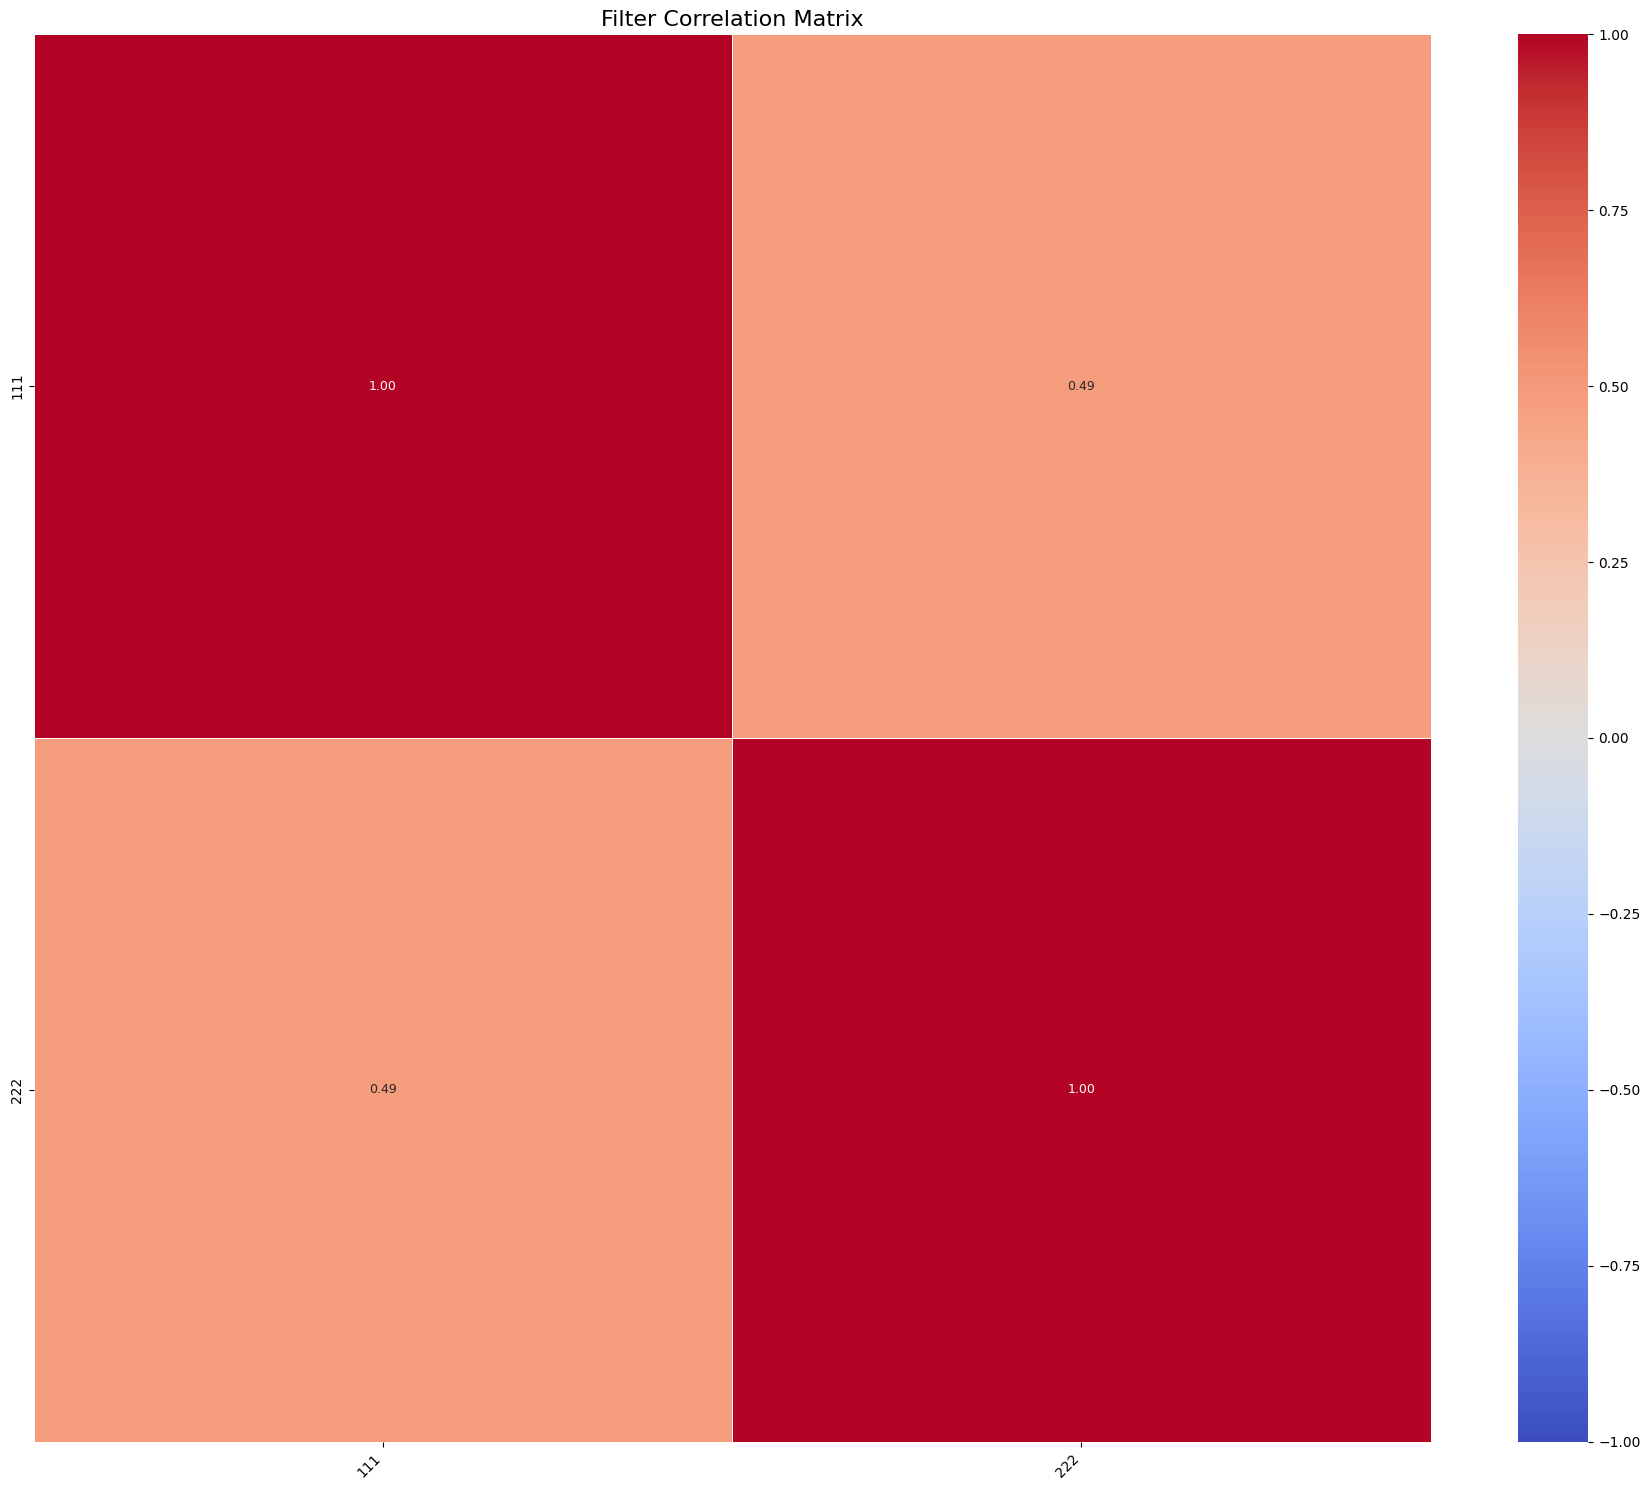

In [4]:
if __name__ == "__main__":
    corr_matrix, filter_results, high_corr_pairs = calculate_filter_correlations()
    plt.show()  # 显示热力图